In [176]:
import numpy as np
import pyxdf
import matplotlib.pyplot as plt
from scipy import signal, fftpack

import mne 
from mne.time_frequency import psd_welch

## check no-TACS data 

In [375]:
## import no-tacs data

data, header=  pyxdf.load_xdf('../recordings/P02-no-tacs-R2.xdf')

if data[0]['info']['name'][0] == 'ExperimentMarkers': 
    markers_data = data[0] 
    opm_data = data[1]
else: 
    markers_data = data[1]   
    opm_data = data[0]

fs = 1000 # sampling rate 


In [376]:
## setting up the data for processing 

start = 10 # seconds in 
end = 10 #seocnds before it ends
adc_diode_idx = 0
adc_tacs_idx = 11
opm_data_cut = opm_data['time_series'][start*fs:-end*fs, :] * 1e-15 #in tesla
time_stamps = opm_data['time_stamps'][start*fs:-end*fs] * 1e-15
num_channels_w_adcs = opm_data_cut.shape[1]
num_samples = opm_data_cut.shape[0]

adc_diode = opm_data_cut[:, adc_diode_idx]
adc_tacs = opm_data_cut[:, adc_tacs_idx]

opm_data_cut = np.delete(opm_data_cut, adc_tacs_idx, 1)
opm_data_cut = np.delete(opm_data_cut, adc_diode_idx, 1)

# plt.plot(adc_diode)

In [377]:
## checking the flicker timing recorded by the photodiode on the projector
adc_diode = np.where(adc_diode > 0.00445, 1, 0)
on = False
for idx, x in enumerate(adc_diode): 
    if x==1 and not on: ## if this is the first one
        on = True
    elif x==1 and on: ## during the on period.
        adc_diode[idx] = 0 
        if idx+1==adc_diode.shape[0] or adc_diode[idx+1] == 0: ## if this is the last one
            adc_diode[idx] = 1 
            on = False

# get the timing on between flickers. It should be 0.1 s interval (10hz flicker) + random ITI 
index_diode_on = np.where(adc_diode == 1)[0] 
timing_diode = np.diff(time_stamps[index_diode_on])
# plt.plot(timing_diode[:50])


In [260]:
## see the flickers with the OPM data

# plt.plot(time_stamps[650:1650], opm_data_cut[650:1650,0])
# for i in index_diode_on[:10]:
#     plt.axvline(x=time_stamps[i], color='red')

## make a time-series of the visual stimulus

    

In [378]:
# channel names according to the order of the OPM data without the ADCs
channel_names = np.zeros(shape=[num_channels_w_adcs], dtype='object') 
channel_types = np.zeros(shape=[num_channels_w_adcs], dtype='object')
channel_units = np.zeros(shape=[num_channels_w_adcs], dtype='object')
for i, channel in enumerate(opm_data['info']['desc'][0]['channels'][0]['channel']):
    # print(channel)
    channel_names[i] = channel['label'][0]
    channel_types[i] = channel['type'][0]
    channel_units[i] = channel['unit'][0]

channel_names = np.delete(channel_names, adc_tacs_idx)
channel_names = np.delete(channel_names, adc_diode_idx)

channel_types = np.delete(channel_types, adc_tacs_idx)
channel_types = np.delete(channel_types, adc_diode_idx)



## analyze OPM data

Creating RawArray with float64 data, n_channels=15, n_times=9000
    Range : 0 ... 8999 =      0.000 ...     8.999 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 1651 samples (1.651 sec)

Effective window size : 2.500 (s)


<ipython-input-386-493f0e3660b7>:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=30, n_fft=2500)


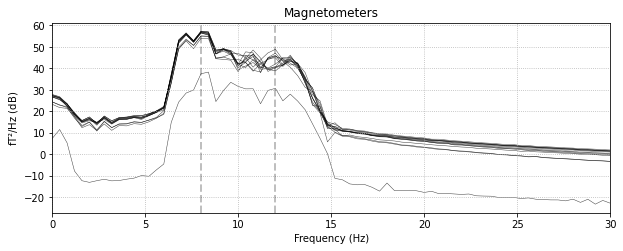

Effective window size : 2.500 (s)


Text(0, 0.5, 'Power')

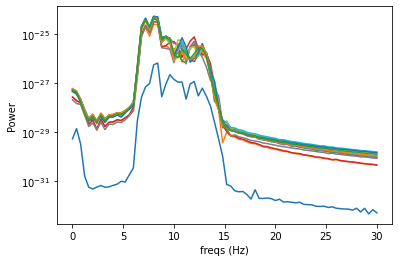

In [386]:
%matplotlib inline
info = mne.create_info(list(channel_names), fs, list(channel_types))
raw = mne.io.RawArray(opm_data_cut[1000:10000].T, info)
raw.drop_channels(['01:01:50', '01:02:50'])

raw.filter(8,12)
raw.plot_psd(fmax=30, n_fft=2500)

pxx, f = psd_welch(raw,fmax=30, n_fft=2500)

for i in range(opm_data_cut.shape[1]-2):
    plt.semilogy(f, pxx[i-1])
plt.xlabel("freqs (Hz)")
plt.ylabel("Power")

# raw.plot(scalings=dict(mag=1e-12), duration=5, start=10)




(13, 10000)


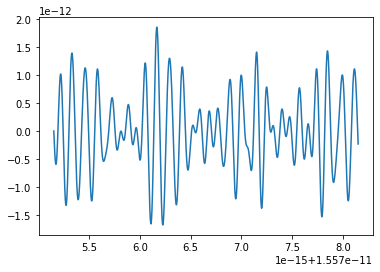

In [382]:
raw_arr = raw[:][0]
print(raw_arr.shape)
plt.plot(time_stamps[:3000], raw_arr[2, :3000])
